# Analise and predict, who'll survive

## Downloading and importing required libraries

In [1]:
!pip install --upgrade pip
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.8 MB ? eta -:--:--

     ━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.6/1.8 MB 17.4 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.2 MB/s eta 0:00:00


  Attempting uninstall: pip
    Found existing installation: pip 23.0.1


    Uninstalling pip-23.0.1:


      Successfully uninstalled pip-23.0.1


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
(pd.__version__,
 np.__version__,
 sns.__version__)

('2.2.3', '2.0.2', '0.13.2')

In [4]:
sns.set_theme()
pal = sns.set_palette([
    "#FF6347", "#4682B4", "#8A2BE2", "#FFD700", "#32CD32",
    "#FF4500", "#1E90FF", "#FF1493", "#00FA9A", "#FFDAB9",
    "#6A5ACD", "#FF8C00", "#ADFF2F", "#20B2AA", "#FF69B4",
    "#7B68EE", "#FFB6C1", "#00BFFF", "#F08080", "#DDA0DD"
])

## EDA

In [5]:
data = pd.read_csv("/kaggle/input/titanic/train.csv", sep=',')

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
data.shape

(891, 12)

In [7]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
data['PassengerId'].shape[0] == data['PassengerId'].unique().shape[0]

True

In [10]:
data = data.drop(columns=['PassengerId'])

In [11]:
data_test = pd.read_csv("/kaggle/input/titanic/test.csv", sep=',')

data_test.shape

(418, 11)

In [12]:
passangerID = data_test.pop('PassengerId')

passangerID.head()

0    892
1    893
2    894
3    895
4    896
Name: PassengerId, dtype: int64

In [13]:
df_numericalvars = data.select_dtypes(include=['float64', 'int64'])

In [14]:
df_numericalvars.columns

Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

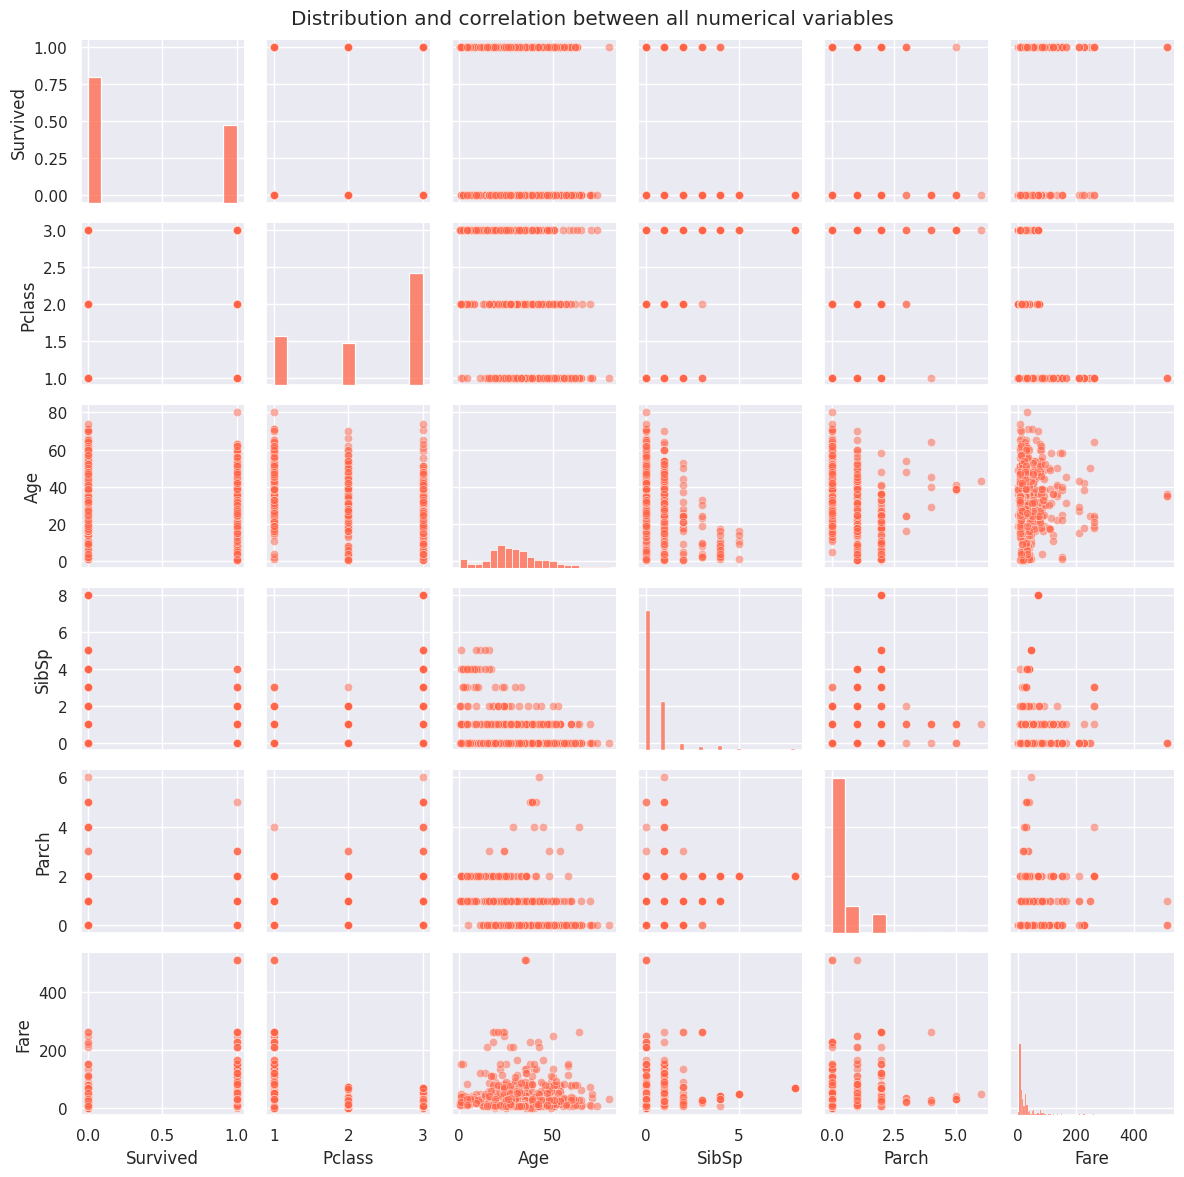

In [15]:
ax = sns.pairplot(df_numericalvars, height=2, plot_kws={'alpha': .5})
ax.fig.suptitle('Distribution and correlation between all numerical variables')
ax.fig.tight_layout()

In [16]:
corrsnum = df_numericalvars.corr()

Text(0.5, 1.03, 'Correlation between selected variables')

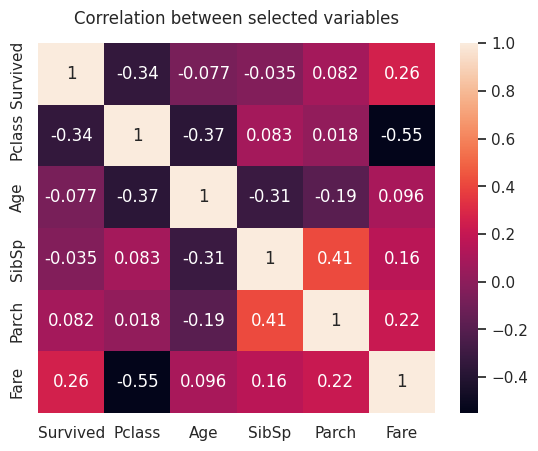

In [17]:
ax = sns.heatmap(corrsnum, annot=True)
ax.set_title('Correlation between selected variables', y=1.03)

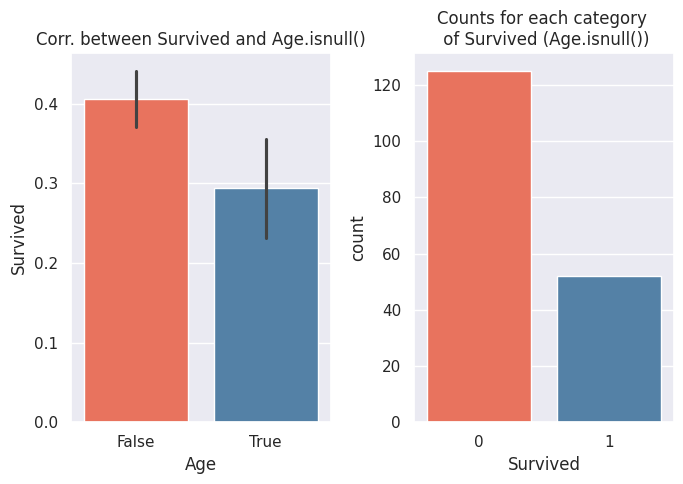

In [18]:
fig = plt.figure(figsize=(7, 5))
(ax1, ax2) = fig.subplots(1, 2)

sns.barplot(x=df_numericalvars['Age'].isnull(), y=df_numericalvars['Survived'], ax=ax1, hue=df_numericalvars['Age'].isnull(), legend=False)
ax1.set_title('Corr. between Survived and Age.isnull()')

sns.countplot(data=df_numericalvars[df_numericalvars['Age'].isnull()], x='Survived', ax=ax2, hue='Survived', legend=False)
ax2.set_title('Counts for each category \n of Survived (Age.isnull())')

fig.tight_layout()


In [19]:
np.corrcoef(df_numericalvars['Age'].isnull(), df_numericalvars['Survived'])

array([[ 1.        , -0.09219652],
       [-0.09219652,  1.        ]])

In [20]:
data['hasAge'] = (data['Age'].notnull()).astype('float64')

In [21]:
ageFormatterNA = pd.concat([data, data_test], axis=0).groupby(['Parch', 'SibSp'])['Age'].transform('mean').round()

ageFormatterNA.head()

0    34.0
1    34.0
2    32.0
3    34.0
4    32.0
Name: Age, dtype: float64

In [22]:
data['Age'] = data['Age'].fillna(ageFormatterNA.iloc[:data.shape[0]])

<Axes: >

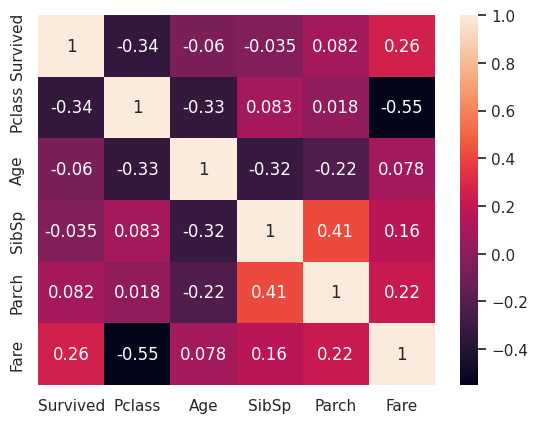

In [23]:
sns.heatmap(data[df_numericalvars.columns].corr(), annot=True)

In [24]:
pclassEncoder = OneHotEncoder(sparse_output=False)
pclassPrep = pclassEncoder.fit_transform(data['Pclass'].to_numpy().reshape(-1, 1))
data = pd.concat([data, pd.DataFrame(pclassPrep, columns=pclassEncoder.get_feature_names_out(['Pclass']))], axis=1)

Text(0.5, 1.02, 'Distribution of Fare depending on Survived')

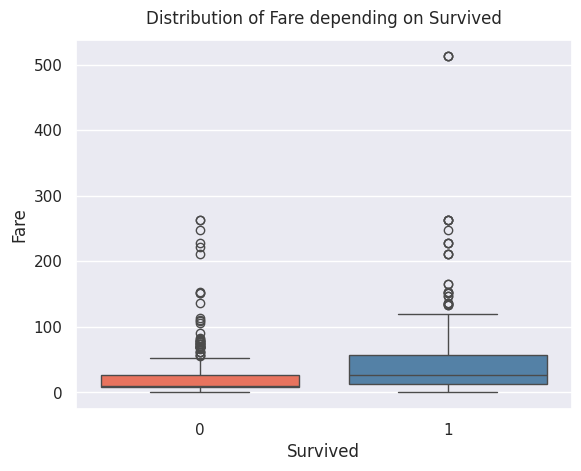

In [25]:
ax = sns.boxplot(data, x='Survived', y='Fare', hue='Survived', legend=False)
ax.set_title('Distribution of Fare depending on Survived', y=1.02)

In [26]:
df_objvars = data.select_dtypes('object')

df_objvars.columns

Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')

In [27]:
data.drop(columns=['Name'], inplace=True)

***drop nonvaluebale variable***

In [28]:
df_objvars['Sex'].unique()

array(['male', 'female'], dtype=object)

Text(0.5, 1.03, 'Quantity for each category value')

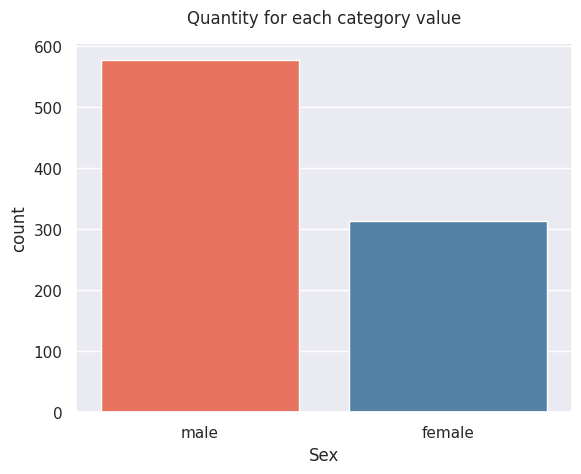

In [29]:
ax = sns.countplot(data, x='Sex', hue='Sex')
ax.set_title('Quantity for each category value', y=1.03)

Text(0.5, 1.03, 'Correlation between survival rates by sex')

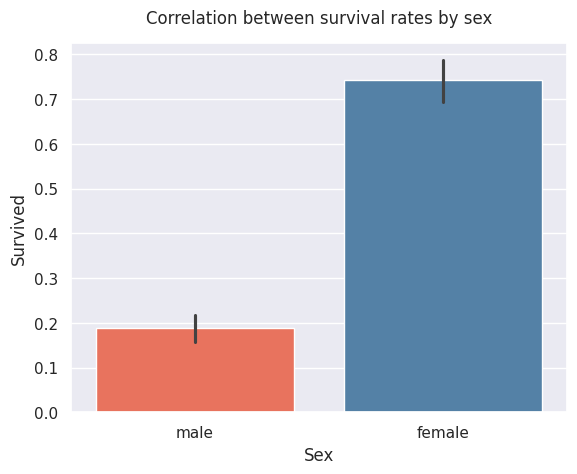

In [30]:
ax = sns.barplot(data, x='Sex', y='Survived', hue='Sex', legend=False)
ax.set_title('Correlation between survival rates by sex', y=1.03)

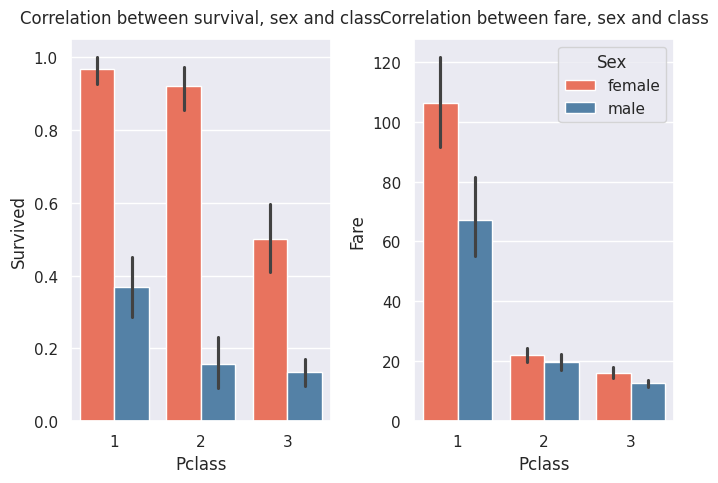

In [31]:
fig = plt.figure(figsize=(7, 5))
(ax1, ax2) = fig.subplots(1, 2)

sns.barplot(data, x='Pclass', y='Survived', hue='Sex', ax=ax1)
ax1.set_title('Correlation between survival, sex and class', y=1.02)
ax1.get_legend().remove()

sns.barplot(data, x='Pclass', y='Fare', hue='Sex', ax=ax2)
ax2.set_title('Correlation between fare, sex and class', y=1.02)
fig.tight_layout()

***we can already tell from this data the relationship between Survived and Sex***

In [32]:
sexEncoder = OneHotEncoder(sparse_output=False)
prepSex = sexEncoder.fit_transform(data['Sex'].to_numpy().reshape(-1, 1))

data = pd.concat([data, pd.DataFrame(prepSex, columns=sexEncoder.get_feature_names_out(['Sex']))], axis=1)

In [33]:
df_objvars['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

In [34]:
df_objvars['Ticket'].value_counts().head()

Ticket
1601        7
CA. 2343    7
347082      7
3101295     6
CA 2144     6
Name: count, dtype: int64

In [35]:
data.loc[data['Ticket'] == '347082']

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,hasAge,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male
13,0,3,male,39.0,1,5,347082,31.275,NaN,S,1.0,0.0,0.0,1.0,0.0,1.0
119,0,3,female,2.0,4,2,347082,31.275,NaN,S,1.0,0.0,0.0,1.0,1.0,0.0
541,0,3,female,9.0,4,2,347082,31.275,NaN,S,1.0,0.0,0.0,1.0,1.0,0.0
542,0,3,female,11.0,4,2,347082,31.275,NaN,S,1.0,0.0,0.0,1.0,1.0,0.0
610,0,3,female,39.0,1,5,347082,31.275,NaN,S,1.0,0.0,0.0,1.0,1.0,0.0
813,0,3,female,6.0,4,2,347082,31.275,NaN,S,1.0,0.0,0.0,1.0,1.0,0.0
850,0,3,male,4.0,4,2,347082,31.275,NaN,S,1.0,0.0,0.0,1.0,0.0,1.0


In [36]:
data.loc[data['Pclass'] == 1]['Ticket'].head()

1     PC 17599
3       113803
6        17463
11      113783
23      113788
Name: Ticket, dtype: object

In [37]:
data.groupby(by=[data['Ticket'].str[0], 'Pclass'])['Survived'].apply(lambda x : (x.sum() / x.count()).round(2)).head(17)

Ticket  Pclass
1       1         0.64
        2         0.00
        3         0.67
2       1         1.00
        2         0.49
        3         0.38
3       1         0.57
        2         0.60
        3         0.22
4       3         0.20
5       1         0.00
        3         0.00
6       1         0.00
        3         0.25
7       3         0.11
8       3         0.00
9       3         1.00
Name: Survived, dtype: float64

In [38]:
data['isTicketUniq'] = (data['Ticket'].duplicated()).astype('float64')

ticketEncoder = OneHotEncoder(sparse_output=False)
prepTicket = ticketEncoder.fit_transform(data['isTicketUniq'].to_numpy().reshape(-1, 1))

data = pd.concat([data, pd.DataFrame(prepTicket, columns=ticketEncoder.get_feature_names_out(['isTicketUniq']))], axis=1)

In [39]:
np.corrcoef(data['Survived'], data['Ticket'].str.isdigit().astype(int))[1, 0]

np.float64(0.001491546055020455)

In [40]:
data.drop(columns=['Ticket'], inplace=True)

In [41]:
data.drop(columns=['isTicketUniq'], inplace=True)

In [42]:
data['Cabin'].value_counts()

Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

Text(0.5, 1.02, 'Dependency of Survived on Cabin.isna()')

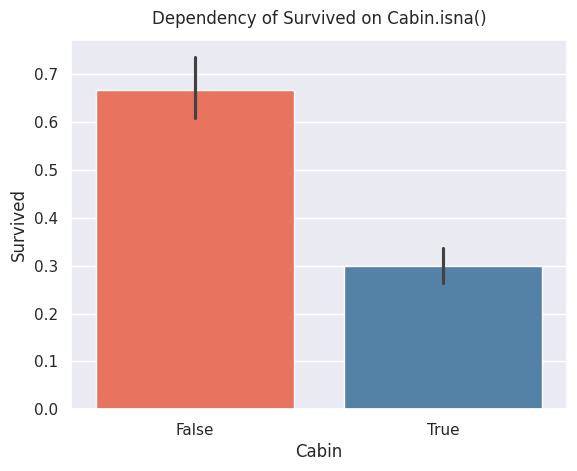

In [43]:
ax = sns.barplot(data, y='Survived', x=data['Cabin'].isna(), hue=data['Cabin'].isna(), legend=False)
ax.set_title('Dependency of Survived on Cabin.isna()', y=1.02)

In [44]:
np.corrcoef(data['Survived'], data['Cabin'].isna().astype('float64'))

array([[ 1.        , -0.31691152],
       [-0.31691152,  1.        ]])

In [45]:
cabChars = data['Cabin'].str[0].value_counts()

cabChars

Cabin
C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: count, dtype: int64

In [46]:
data.groupby(data['Cabin'].str[0])['Survived'].agg(['sum', 'count'])

,sum,count
Cabin,,
A,7,15
B,35,47
C,35,59
D,25,33
E,24,32
F,8,13
G,2,4
T,0,1


In [47]:
data.groupby(data['Cabin'].str[0])['Pclass'].value_counts()

Cabin  Pclass
A      1         15
B      1         47
C      1         59
D      1         29
       2          4
E      1         25
       2          4
       3          3
F      2          8
       3          5
G      3          4
T      1          1
Name: count, dtype: int64

In [48]:
np.corrcoef(data.loc[~data['Cabin'].isna()]['Survived'], data['Cabin'].dropna().str[0].map({'ABCDEFGT'[i] : i for i in range(8)}))

array([[1.        , 0.01882525],
       [0.01882525, 1.        ]])

<Axes: >

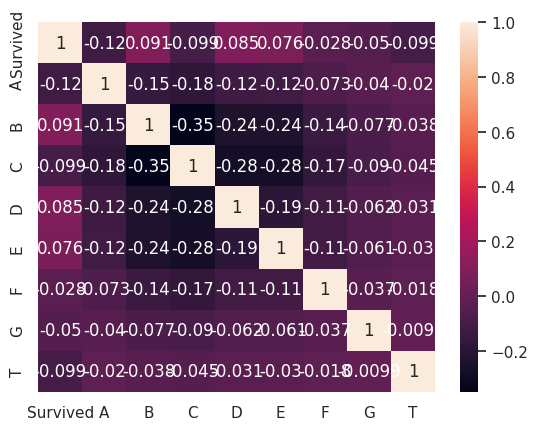

In [49]:
sns.heatmap(pd.concat([data.loc[~data['Cabin'].isna()]['Survived'], pd.get_dummies(data['Cabin'].dropna().str[0])], axis=1).corr(), annot=True)

***...skip***

In [50]:
data['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

<Axes: xlabel='Embarked', ylabel='Survived'>

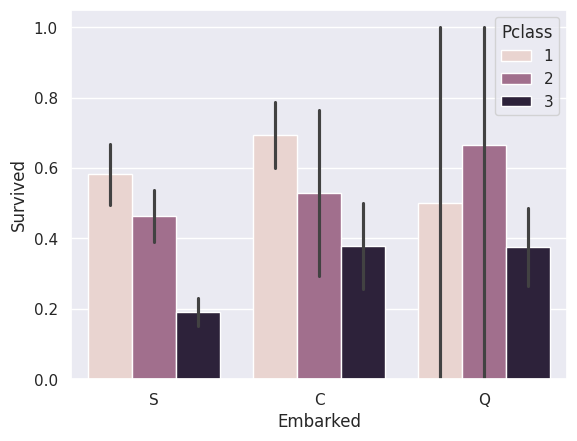

In [51]:
sns.barplot(data, x='Embarked', y='Survived', hue='Pclass')

<Axes: xlabel='Embarked', ylabel='count'>

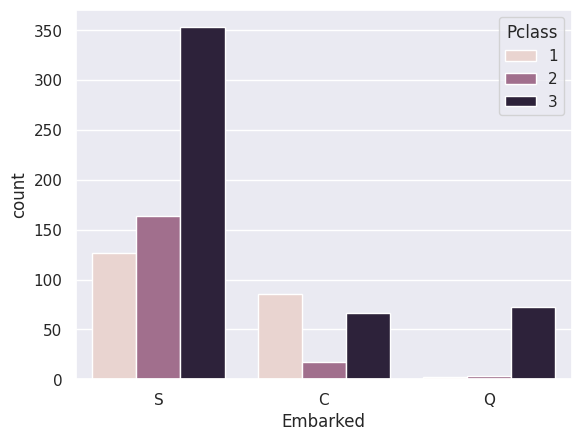

In [52]:
sns.countplot(data, x='Embarked', hue='Pclass')

In [53]:
data[data['Embarked'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,hasAge,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,isTicketUniq_0.0,isTicketUniq_1.0
61,1,1,female,38.0,0,0,80.0,B28,NaN,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
829,1,1,female,62.0,0,0,80.0,B28,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


In [54]:
data['Embarked'] = data['Embarked'].fillna('C')

In [55]:
embarkedEncoder = OneHotEncoder(sparse_output=False)
prepEmb = embarkedEncoder.fit_transform(data['Embarked'].to_numpy().reshape(-1, 1))

In [56]:
data = pd.concat([data, pd.DataFrame(prepEmb, columns=embarkedEncoder.get_feature_names_out(['Embarked']))], axis=1)

In [57]:
pClassData = data.pop('Pclass')

## Training and testing model

In [58]:
features = data.select_dtypes(include=['float64', 'int64']).drop(columns=['Survived']).columns

features

Index(['Age', 'SibSp', 'Parch', 'Fare', 'hasAge', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'isTicketUniq_0.0',
       'isTicketUniq_1.0', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [59]:
X, Y = data[features].to_numpy(), data['Survived'].to_numpy()

X.shape, Y.shape

((891, 15), (891,))

In [60]:
accuracies = []
scores = []

for (train_inds, test_inds) in KFold(n_splits=4).split(X) :

    X_train, X_test, Y_train, Y_test = X[train_inds, :], X[test_inds, :], Y[train_inds], Y[test_inds]
    model = RandomForestClassifier(random_state=42, n_estimators=120)
    model.fit(X_train, Y_train)
    scores.append(model.score(X_test, Y_test))
    Y_pred = model.predict(X_test)
    accuracies.append(f1_score(Y_test, Y_pred))

In [61]:
(np.mean(scores), np.mean(accuracies))

(np.float64(0.7969084555407426), np.float64(0.720531733794094))

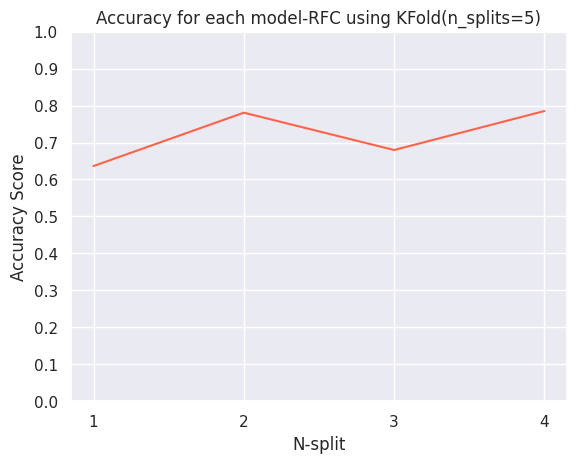

In [62]:
ax=sns.lineplot(x=np.arange(4)+1, y=accuracies)
ax.set_title('Accuracy for each model-RFC using KFold(n_splits=5)')
ax.set_xlabel('N-split')
ax.set_ylabel('Accuracy Score')
ax.set_xticks(np.arange(4)+1)
ax.set_yticks(np.arange(0, 1.1, 0.1))

In [63]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [64]:
model = DecisionTreeClassifier(random_state=42)

param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(1, 21)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),   
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': [None, 'balanced'],  
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                   n_iter=100, cv=3, n_jobs=-1, verbose=1,
                                   random_state=42)

random_search.fit(X_train, Y_train)
best_params = random_search.best_params_

best_model = random_search.best_estimator_
predictions = best_model.predict(X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [65]:
(accuracy_score(Y_test, predictions), f1_score(Y_test, predictions), roc_auc_score(Y_test, predictions))

(0.7988826815642458, 0.7352941176470589, np.float64(0.7806949806949807))

In [66]:
rfc_model = RandomForestClassifier(random_state=42)

param_grid = {
    'max_depth' : np.arange(1, 10).tolist() + [None],
    'n_estimators' : np.arange(100, 300, 25),
    'min_samples_split' : np.arange(1, 5).tolist() + [None],
    'min_samples_leaf': np.arange(1, 8).tolist() + [None],
}

skf = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(estimator=rfc_model,
                           param_grid=param_grid,
                           n_jobs=-1,
                           cv=skf,
                           scoring="roc_auc",
                           verbose=1)

grid_search.fit(X, Y)

best_rf_classifier = grid_search.best_estimator_

Fitting 10 folds for each of 3200 candidates, totalling 32000 fits


In [67]:
grid_search.best_score_

np.float64(0.8711660583425289)

Text(0.5, 0, 'Mean Test Score')

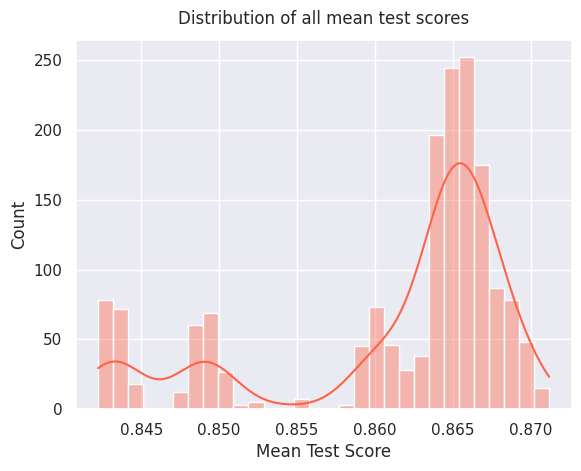

In [68]:
ax = sns.histplot(x=grid_search.cv_results_['mean_test_score'], kde=True, alpha=.4, bins=30)
ax.set_title('Distribution of all mean test scores', y=1.02)
ax.set_xlabel('Mean Test Score')

In [69]:
pd.Series(grid_search.best_params_)

max_depth              NaN
min_samples_leaf       6.0
min_samples_split      2.0
n_estimators         100.0
dtype: float64

Text(0, 0.5, 'Feature')

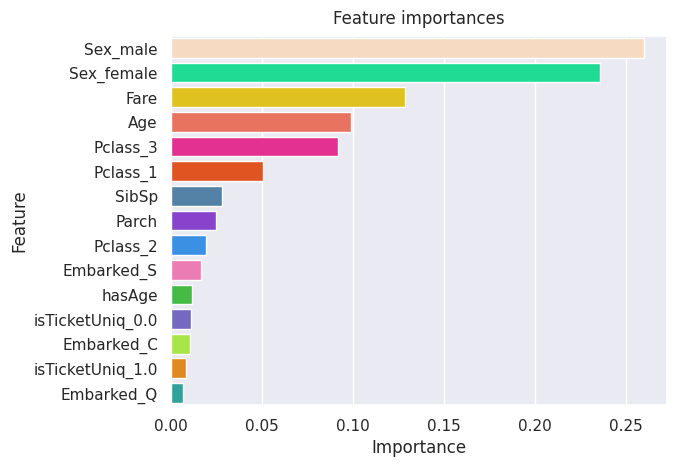

In [70]:
ax = sns.barplot(
    x=best_rf_classifier.feature_importances_, 
    y=features, 
    orient='h', 
    order=features[np.argsort(best_rf_classifier.feature_importances_)][::-1], 
    hue=features)
ax.set_title('Feature importances', y=1.01)
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

## Submissions

In [71]:
data_test['hasAge'] = (data_test['Age'].notnull()).astype('float64')

data_test['Age'] = data_test['Age'].fillna(ageFormatterNA.iloc[data.shape[0]:])

data_test['Fare'] = data_test['Fare'].fillna(data['Fare'].groupby(pClassData).transform('mean'))

pclassEncoder = OneHotEncoder(sparse_output=False)
pclassPrep = pclassEncoder.fit_transform(data_test['Pclass'].to_numpy().reshape(-1, 1))
data_test = pd.concat([data_test, pd.DataFrame(pclassPrep, columns=pclassEncoder.get_feature_names_out(['Pclass']))], axis=1)

data_test['Embarked'] = data_test['Embarked'].fillna('C')
embarkedEncoder = OneHotEncoder(sparse_output=False)
prepEmb = embarkedEncoder.fit_transform(data_test['Embarked'].to_numpy().reshape(-1, 1))
data_test = pd.concat([data_test, pd.DataFrame(prepEmb, columns=embarkedEncoder.get_feature_names_out(['Embarked']))], axis=1)

sexEncoder = OneHotEncoder(sparse_output=False)
prepSex = sexEncoder.fit_transform(data_test['Sex'].to_numpy().reshape(-1, 1))
data_test = pd.concat([data_test, pd.DataFrame(prepSex, columns=sexEncoder.get_feature_names_out(['Sex']))], axis=1)

data_test['isTicketUniq'] = (data_test['Ticket'].duplicated()).astype('float64')
ticketEncoder = OneHotEncoder(sparse_output=False)
prepTicket = ticketEncoder.fit_transform(data_test['isTicketUniq'].to_numpy().reshape(-1, 1))
data_test = pd.concat([data_test, pd.DataFrame(prepTicket, columns=ticketEncoder.get_feature_names_out(['isTicketUniq']))], axis=1)

In [72]:
X_submission = data_test[features].to_numpy()

In [73]:
Y_submission = best_rf_classifier.predict(X_submission)

In [74]:
df_submissions = pd.DataFrame({'PassengerId' : passangerID, 'Survived' : Y_submission})

df_submissions.to_csv('/kaggle/working/submission.csv', index=False)

In [75]:
df_submissions.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
